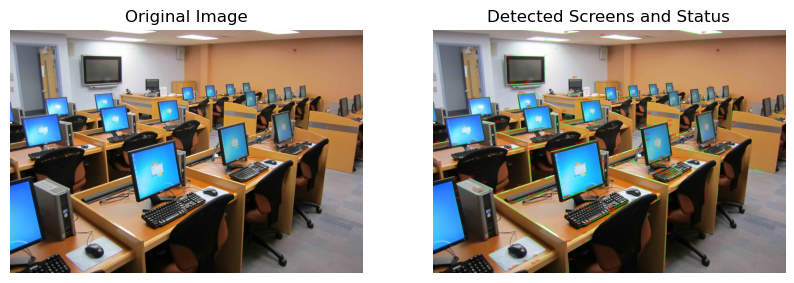

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_screen_on(screen_image):
    if screen_image.size == 0:  # Check if the image is empty
        return False
    
    avg_intensity = np.mean(screen_image)
    
    threshold = 100  
    return avg_intensity > threshold


image = cv2.imread(r"C:\Users\Hp\Desktop\33ICT-Lab.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

edges = cv2.Canny(blurred, 50, 150)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

line_image = np.copy(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)


        roi = image[y1:y2, x1:x2]

        if is_screen_on(roi):
            cv2.putText(line_image, "ON", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), )
        else:
            cv2.putText(line_image, "OFF", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Screens and Status")
plt.axis('off')

plt.show()


# detecting on/off: i looked it up on internet could find a working solution 


Computer detected!
Monitor detected!
Keyboard detected!


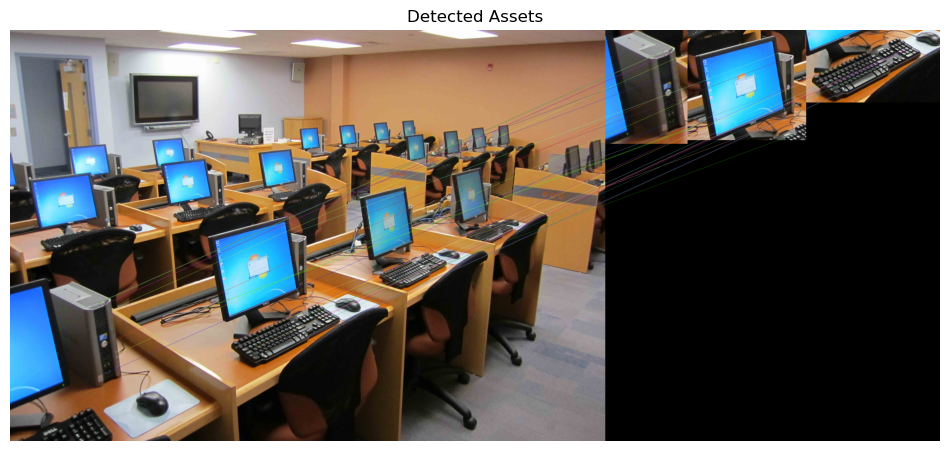

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

computer_image = cv2.imread(r"C:\Users\Hp\Desktop\comp.jpg")
monitor_image = cv2.imread(r"C:\Users\Hp\Desktop\moniter.jpg")
keyboard_image = cv2.imread(r"C:\Users\Hp\Desktop\Keyboard.jpg")

kp_computer, des_computer = compute_sift_features(computer_image)
kp_monitor, des_monitor = compute_sift_features(monitor_image)
kp_keyboard, des_keyboard = compute_sift_features(keyboard_image)

captured_image = cv2.imread(r"C:\Users\Hp\Desktop\33ICT-Lab.jpg")
kp_captured, des_captured = compute_sift_features(captured_image)

matches_computer = match_features(des_captured, des_computer)
matches_monitor = match_features(des_captured, des_monitor)
matches_keyboard = match_features(des_captured, des_keyboard)

computer_threshold = 20
monitor_threshold = 20
keyboard_threshold = 20

if len(matches_computer) > computer_threshold:
    print("Computer detected!")
    matched_image = cv2.drawMatches(captured_image, kp_captured, computer_image, kp_computer, matches_computer[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
else:
    matched_image = captured_image.copy()

if len(matches_monitor) > monitor_threshold:
    print("Monitor detected!")
    matched_image = cv2.drawMatches(matched_image, kp_captured, monitor_image, kp_monitor, matches_monitor[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

if len(matches_keyboard) > keyboard_threshold:
    print("Keyboard detected!")
    matched_image = cv2.drawMatches(matched_image, kp_captured, keyboard_image, kp_keyboard, matches_keyboard[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Assets")
plt.axis('off')
plt.show()



#its onlyu detecting stuff in the first row of the image cuz refernce images of computer moniter and keyboard are from first row

In [16]:
import cv2
import numpy as np

def compute_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def draw_bounding_box(image, keypoints1, keypoints2, matches):
    if len(matches) >= 4:  # Need at least 4 matches for homography
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if M is not None:  # Check if homography was found
            h, w = reference_image.shape[:2]
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)

            image_with_box = cv2.polylines(image, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)
            return image_with_box

    return image  # Return the original image if no bounding box is drawn


reference_image = cv2.imread(r"C:\Users\Hp\Desktop\carlos-sainz-ferrari-f1-75-1.jpg")
kp_reference, des_reference = compute_sift_features(reference_image)

width = 640
height = 360
reference_image = cv2.resize(reference_image, (width, height))

video_path = r"C:\Users\Hp\Downloads\_through goes Hamilton.mp4"
cap = cv2.VideoCapture(video_path)

frame_counter = 0
n = 10 

while cap.isOpened():
    ret, test_image = cap.read()
    if not ret:
        break
    test_image = cv2.resize(test_image, (width, height))
    
    if frame_counter % n == 0:
        test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
        test_image_gray = cv2.equalizeHist(test_image_gray)

        kp_test, des_test = compute_sift_features(test_image_gray)

        if des_reference is not None and des_test is not None:
            matches = match_features(des_reference, des_test)
            image_with_box = draw_bounding_box(test_image, kp_reference, kp_test, matches)
        else:
            image_with_box = test_image.copy()

        cv2.imshow('Object Recognition', image_with_box)

    frame_counter += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

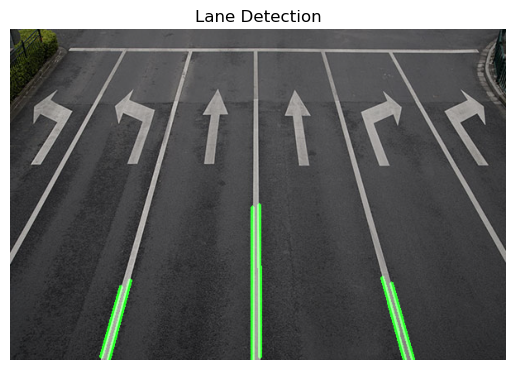

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines):
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

def process_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Define the region of interest
    height, width = edges.shape
    roi_vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)
    roi = region_of_interest(edges, roi_vertices)

    # Hough Line Transformation
    lines = cv2.HoughLinesP(roi, 1, np.pi / 180, threshold=20, minLineLength=20, maxLineGap=50)
    
    # Draw lines on the original image
    line_image = np.zeros_like(image)
    draw_lines(line_image, lines)
    combined = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    
    return combined

# Load an image
image_path = r"C:\Users\Hp\Desktop\Road-Markings.jpg"# Replace with your image path
image = cv2.imread(image_path)

# Process the image
output_image = process_image(image)

# Display the result
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('Lane Detection')
plt.axis('off')
plt.show()


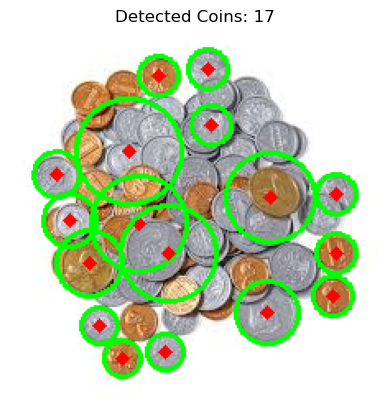

Total coins detected: 17


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_coins(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                                param1=50, param2=30, minRadius=5, maxRadius=50)

    if circles is not None:
        # Convert the (x, y) coordinates and radius of the circles to integers
        circles = np.uint16(np.around(circles))
        count = circles.shape[1]  # Count of detected coins
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)
    else:
        count = 0  # No coins detected

    return image, count

# Load the image containing coins
image_path = r"C:\Users\Hp\Desktop\images (1).jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Detect coins and count them
output_image, coin_count = detect_coins(image)

# Display the results
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Coins: {coin_count}')  # Display the count of coins
plt.axis('off')
plt.show()

print(f'Total coins detected: {coin_count}')  # Print the count of coins in the console


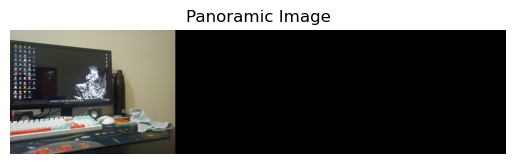

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def stitch_images(images):
    panorama = images[0]  # Initialize panorama with the first image

    for i in range(1, len(images)):
        kp1, des1 = compute_sift_features(panorama)
        kp2, des2 = compute_sift_features(images[i])

        matches = match_features(des1, des2)

        if len(matches) > 4:  # Need at least 4 matches to compute homography
            src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Warp the current image to the panorama
            panorama = cv2.warpPerspective(images[i], M, (panorama.shape[1] + images[i].shape[1], panorama.shape[0]))
            panorama[0:images[i].shape[0], 0:images[i].shape[1]] = images[i]

    return panorama

image_paths = [
    r"C:\Users\Hp\Desktop\WhatsApp Image 2024-09-30 at 19.42.05_4304a90b.jpg",
    r"C:\Users\Hp\Desktop\WhatsApp Image 2024-09-30 at 19.42.04_ba657ad0.jpg",
    r"C:\Users\Hp\Desktop\WhatsApp Image 2024-09-30 at 19.42.04_db0546d3.jpg"
]

images = [cv2.imread(path) for path in image_paths]

# Ensure all images were loaded properly
if any(image is None for image in images):
    print("Error loading one or more images. Please check the paths.")
else:
    # Create the panoramic image
    panorama = stitch_images(images)

    # Display the result
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.title("Panoramic Image")
    plt.axis('off')
    plt.show()
